# Stock Correlation

We analyse an often heard hypothesis of stock correlations: There are stocks which follow in their trends one after an other within a short time window. If such correlations are predictable, we can exploit them for buy/sell signals. 

Our analysis looks for such correlations and tests whether they follow a predictable pattern.

## Data Preparation (Naive Approach)

We are performing a timeseries analysis. A common approach is test for stationarity and if the series is not stationary, make it stationary using an ARIMA model for instance. In the naive approach, we ignore ARIMA modeling and just shoot at the data with simple instruments, such as linear regression analysis.


This notbook consumes `.csv` files from yahoo finanance and creates a sliding windows of varying size defining a number of samples in order to compute

* the slope using OLS regression within each window
* test for significance incl. p value, $R^2$ value for the OLS regression
* the return if one would buy when the window starts and sell on the window's last day

As a result, there is for each date and window length a vector of KPIs about the stock's behavior within the window at this date.

Finally, the data is stored as a `.parquet` file with the same filename.

### Parameters

In [1]:
import os

input_csv_file = './SMI.CH.csv'
output_file = os.path.splitext(input_csv_file)[0] + '.parquet'

# different window lengths = number of samples to compute the slopes within
win_lengths = range(5,30)

### Imports

In [2]:
# libs we need
import pandas as pd
import statsmodels.api as sm
import numpy as np

# date calculations
from datetime import datetime
from datetime import timedelta

### Helper functions

In [3]:
# computes the return by integer row num given in start_int_idx 
def stock_return(stock, start_int_idx, length, price='close'):
    end_int_idx = start_int_idx + length
    buy_price = stock.iloc[start_int_idx][price]
    sell_price = stock.iloc[end_int_idx][price]
    ret_price = sell_price - buy_price
    ret = ret_price / buy_price 
    return ret

# computes return by index given in start_idx
def stock_return_idx(stock, start_idx, length, price='close'):
    start_int_idx = stock.index.get_loc(start_idx)    
    return stock_return(stock, start_int_idx, length, price)


In [4]:
# True, if date in tuple t <= last_date
def tuple_lessequal_than_last_date(t, last_date):
    tuple_date = datetime.strptime(t[0], '%Y-%m-%d').date()
    tuple_win_length = int(t[1])
    return (tuple_date + timedelta(days=tuple_win_length)) <= last_date

# True, if date in tuple date + length < len(stock)
def tuple_fits_in_stock(stock, t):
    tuple_date = t[0]
    tuple_win_length = int(t[1])
    start_int_idx = stock.index.get_loc(tuple_date)
    end_int_idx = start_int_idx + tuple_win_length
    return end_int_idx < len(stock)

In [5]:
def stock_ols(stock, idx, alpha=0.05, price='close'):
    date_idx, win_length = idx
    start_int_idx = stock.index.get_loc(date_idx)
    end_int_idx = start_int_idx + win_length

    Y = stock.iloc[start_int_idx:end_int_idx+1][price].to_numpy()
    X = np.arange(win_length+1)
    X = sm.add_constant(X)

    model = sm.OLS(Y,X)
    res = model.fit()

    # retrieve some values
    rsq = res.rsquared
    slope = res.params[1]
    pval = res.pvalues[1]
    H0_rejected = True if pval < alpha else False

    return [slope, rsq, pval, H0_rejected]
              
# computes the stock kpis and returns them as list
# idx is a tuple of (date, win_length)
def stock_kpi(stock, idx, price='close'):
    slope, rsq, pval, H0_rejected = stock_ols(stock, idx)
    date_idx, win_length = idx
    ret = stock_return_idx(stock, date_idx, win_length)

    return [slope, rsq, ret, pval, H0_rejected]

### Import Data

In [6]:
# Path to data is in parameter 'input_csv_file'

# import data
colnames = ['date', 'open', 'high', 'low', 'close', 'adj_close', 'volume']
stock = pd.read_csv(input_csv_file, delimiter=',', header=0, names=colnames, decimal='.')

In [7]:
stock.head()

,date,open,high,low,close,adj_close,volume
0,2021-09-06,12383.259766,12448.450195,12378.919922,12430.230469,12430.230469,26128800
1,2021-09-07,12420.330078,12420.330078,12322.679688,12344.379883,12344.379883,32887900
2,2021-09-08,12251.040039,12255.889648,12155.629883,12215.139648,12215.139648,38254100
3,2021-09-09,12157.669922,12189.679688,12108.190430,12116.429688,12116.429688,38788900
4,2021-09-10,12128.269531,12158.929688,12049.940430,12060.639648,12060.639648,31418500


In [8]:
stock.set_index('date', inplace=True)
stock.sort_index(ascending=True, inplace=True)

In [9]:
#
# Some testing
#
import random
wlen = 10
date_idx = random.choice(stock.index[:-1-wlen])
date_int_idx = stock.index.get_loc(date_idx)

# assert that both functions return the same
assert stock_return_idx(stock, date_idx, wlen) == stock_return(stock, date_int_idx, wlen)

### Compile new Dataframe with Stock KPIs

For each tuple of date and window length compute the KPIs 

* slope
* $R^2$
* stock return
* p value
* H0 (slope == 0) rejected 

... and add them to a new dataframe.

In [10]:
# Compute new multiindex from cartesian product of date x win_lengts
date_array = stock.index.to_numpy()
w_len_array = np.array(win_lengths)

date_array_times_w_len = np.repeat(date_array, len(w_len_array))
w_len_array_times_date = np.array(list(w_len_array)*len(date_array))
assert len(date_array_times_w_len) == len(w_len_array_times_date)

arrays = [date_array_times_w_len, w_len_array_times_date]
tuples = list(zip(*arrays))

In [11]:
# Remove index tuples if win_length exceeds stock's last_date
new_tuples = [t for t in tuples if tuple_fits_in_stock(stock, t) is True]
assert len(new_tuples) < len(tuples)

In [12]:
# compile multiindex from tuples
midx = pd.MultiIndex.from_tuples(new_tuples, names=["date", "win_length"])
# create dataframe on multiindex
stock_slope_returns = pd.DataFrame(data=None, index=midx, columns=['slope', 'rsquared', 'return', 'pval', 'H0_rejected'])

In [13]:
# compute stock KPIs for all indices and window lengths
for i in range(len(stock_slope_returns)):
    idx = midx[i]
    stock_slope_returns.loc[idx] = stock_kpi(stock, idx) 

In [14]:
# Example return statistics for true slopes and returns > X
import statistics

stock_slope_returns__real_slope = stock_slope_returns[stock_slope_returns['H0_rejected'] == True]
mean_return_real_slope = statistics.mean(stock_slope_returns__real_slope['return'])
print("Average return: {}".format(mean_return_real_slope))

Average return: -0.00444830081392989


### Plot Distributions 

We look at the distribution of slopes. Is there a tendency, i.e. are certain slopes preferred? Some slopes are not statistically significant. Will there be a preference in slopes, if we remove non-significant slopes?

In [15]:
df_all_slopes = pd.DataFrame(data=stock_slope_returns).reset_index()
df_all_slopes.slope = df_all_slopes.slope.astype(float)

df_real_slopes = pd.DataFrame(data=stock_slope_returns__real_slope).reset_index()
df_real_slopes.slope = df_real_slopes.slope.astype(float)

Text(0.5, 1.0, 'Significant slopes only')

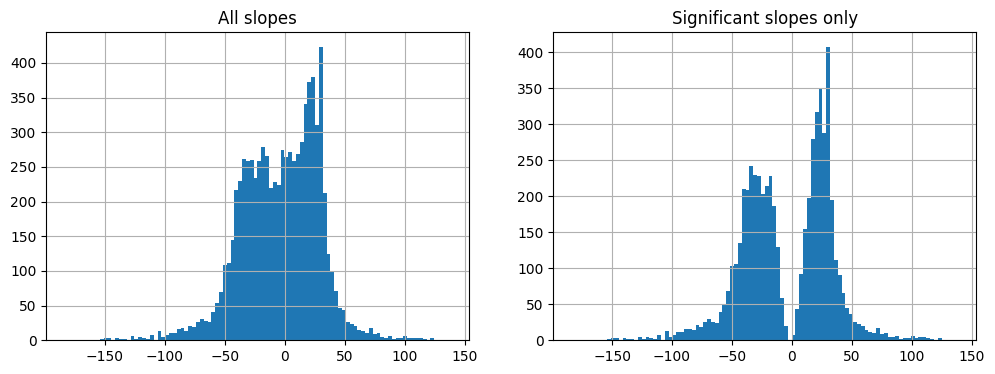

In [16]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
df_all_slopes.slope.hist(bins=100, ax=axes[0])
axes[0].set_title('All slopes')
df_real_slopes.slope.hist(bins=100, ax=axes[1])
axes[1].set_title('Significant slopes only')

Text(0.5, 1.0, 'Significant slopes only')

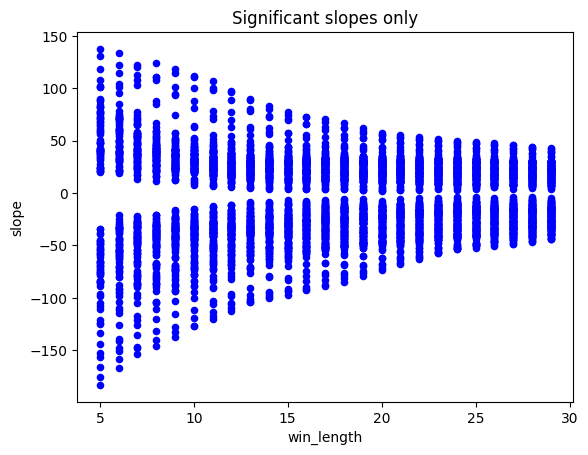

In [17]:
df_real_slopes.win_length = df_real_slopes.win_length.astype(float)
df_real_slopes.slope  = df_real_slopes.slope.astype(float)
ax1 = df_real_slopes.plot(kind='scatter', x='win_length', y='slope', color='b')
ax1.set_title('Significant slopes only')

### Some simple tests

We test for normality of the slopes distirbution and perform a multiple comparison Tukey’s range test to compare means of all pairs of groups.

In [18]:
# Anderson-Darling and Kolmogorov-Smirnov test
# for normality of slope distribution
# Source: 
#  https://www.statsmodels.org/dev/generated/statsmodels.stats.diagnostic.normal_ad.html
#  https://www.statsmodels.org/dev/generated/statsmodels.stats.diagnostic.kstest_fit.html#statsmodels.stats.diagnostic.kstest_fit
alpha = 0.05
slope_thresh = 10 # cut off slope distr. left and right for values larger than threshold

df = df_all_slopes

print("H0: data follows a normal distribution")
for w in win_lengths:
    df_by_win_length = df[df['win_length']==w]
    df_by_win_length = df[abs(df['slope'])<slope_thresh]
    ad_teststatistic = sm.stats.diagnostic.normal_ad(df_by_win_length['slope'])
    # H0: data follows a normal distribution
    H0_rejected_ad = True if (ad_teststatistic[1] < alpha) else False
    ks_teststatistic = sm.stats.diagnostic.kstest_fit(df_by_win_length['slope'])
    H0_rejected_ks = True if (ks_teststatistic[1] < alpha) else False
    print("Win length: {} // H0_rejected_ad: {} // H0_rejected_ks: {}".format(w, H0_rejected_ad, H0_rejected_ks))

H0: data follows a normal distribution
Win length: 5 // H0_rejected_ad: True // H0_rejected_ks: True
Win length: 6 // H0_rejected_ad: True // H0_rejected_ks: True
Win length: 7 // H0_rejected_ad: True // H0_rejected_ks: True
Win length: 8 // H0_rejected_ad: True // H0_rejected_ks: True
Win length: 9 // H0_rejected_ad: True // H0_rejected_ks: True
Win length: 10 // H0_rejected_ad: True // H0_rejected_ks: True
Win length: 11 // H0_rejected_ad: True // H0_rejected_ks: True
Win length: 12 // H0_rejected_ad: True // H0_rejected_ks: True
Win length: 13 // H0_rejected_ad: True // H0_rejected_ks: True
Win length: 14 // H0_rejected_ad: True // H0_rejected_ks: True
Win length: 15 // H0_rejected_ad: True // H0_rejected_ks: True
Win length: 16 // H0_rejected_ad: True // H0_rejected_ks: True
Win length: 17 // H0_rejected_ad: True // H0_rejected_ks: True
Win length: 18 // H0_rejected_ad: True // H0_rejected_ks: True
Win length: 19 // H0_rejected_ad: True // H0_rejected_ks: True
Win length: 20 // H0_

In [19]:
# Tests for multiple comparisons
# Tukey’s range test to compare means of all pairs of groups

df = df_real_slopes

from statsmodels import sandbox as sb
mc = sb.stats.multicomp.MultiComparison(data=df['slope'], groups=df['win_length'])
res_tukeyhsd = mc.tukeyhsd(alpha=0.05)

# H0: pairwise means are the same
# if .rejects shows False, H0 is not rejected, i.e. we cannot say that means are different
all_rejected = not res_tukeyhsd.reject.all()
any_true = res_tukeyhsd.reject.any()

print('Any mean different? - {}'.format(any_true))
print('All pairwise means are the same? - {}'.format(all_rejected))

/opt/conda/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1151: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Any mean different? - False
Pairwise means are the same? - True


### Store Features in `.parquet` File

Output file name in variable `output_file`

In [20]:
stock_slope_returns.to_parquet(path=output_file, index=True)